# Library Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor




c:\Users\xaviv\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data obtention and preprocessing

## Dataset loader

In [3]:
# Set the path to the file you'd like to load
file_path = "insurance.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mirichoi0218/insurance",
  file_path,
)
# Afegir una columna 'id' que comença en 1
df.insert(0, "id", range(0, len(df)))
df.to_csv("insurance.csv", index=False)
print("First 5 records:\n", df.head())

C:\Users\xaviv\AppData\Local\Temp\ipykernel_28120\268662106.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:
    id  age     sex     bmi  children smoker     region      charges
0   0   19  female  27.900         0    yes  southwest  16884.92400
1   1   18    male  33.770         1     no  southeast   1725.55230
2   2   28    male  33.000         3     no  southeast   4449.46200
3   3   33    male  22.705         0     no  northwest  21984.47061
4   4   32    male  28.880         0     no  northwest   3866.85520


## Preprocessing

### Step 1:
Identify non physic rows

In [4]:
def remove_non_physic_rows(df):
    non_physic_rows = df[
        (df['age'] <= 0) |
        (df['bmi'] <= 0) |
        (df['children'] < 0) |
        (df['charges'] < 0)
    ]

    df = df.drop(non_physic_rows.index) # Eliminar aquelles files que contenen valors no físics
    return df

ini_size = df.shape[0]
df = remove_non_physic_rows(df)
print(f"Del dataset s'han eliminat {ini_size - df.shape[0]} files no físiques. Dades restants: {df.shape[0]}")

Del dataset s'han eliminat 0 files no físiques. Dades restants: 1338


Data normalization --> Numerical MinMaxScaler

In [5]:


# 2️⃣ Columnes numèriques a normalitzar
cols_num = ["age", "bmi", "children", "charges"]

# 3️⃣ Crear scaler i aplicar-lo
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df[cols_num]), columns=[col + "_norm" for col in cols_num])

# 4️⃣ Afegir les columnes normalitzades al costat de les originals
df_final = pd.concat([df, df_norm], axis=1)

# 5️⃣ Mostrar resultat
print(df_final.head(5))


   id  age     sex     bmi  children smoker     region      charges  age_norm  \
0   0   19  female  27.900         0    yes  southwest  16884.92400  0.021739   
1   1   18    male  33.770         1     no  southeast   1725.55230  0.000000   
2   2   28    male  33.000         3     no  southeast   4449.46200  0.217391   
3   3   33    male  22.705         0     no  northwest  21984.47061  0.326087   
4   4   32    male  28.880         0     no  northwest   3866.85520  0.304348   

   bmi_norm  children_norm  charges_norm  
0  0.321227            0.0      0.251611  
1  0.479150            0.2      0.009636  
2  0.458434            0.6      0.053115  
3  0.181464            0.0      0.333010  
4  0.347592            0.0      0.043816  


### Step 2: Outlier Detection and processing


Boxplots for outlier detection

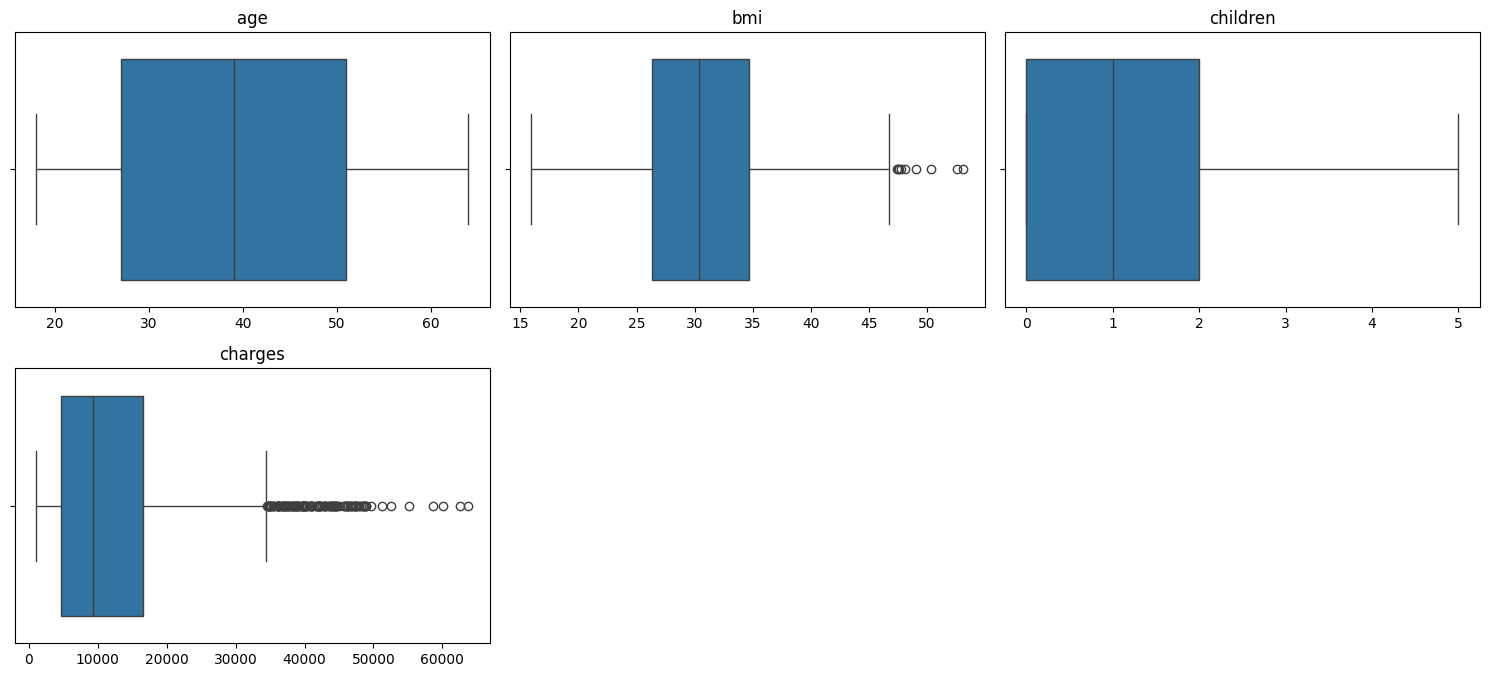

In [6]:
# Boxplots per detectar outliers
def display_distribution_bp(df):
    numeric_cols = ['age', 'bmi', 'children', 'charges']

    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols):
        plt.subplot(3, 3, i+1)
        sns.boxplot(x=df[col])
        plt.title(col)
        plt.xlabel('')
    plt.tight_layout()
    plt.show()

display_distribution_bp(df)


Create separate dataset with the outliers from this step, for later discussion

In [7]:
outliers = df[
    (df['bmi'] > 46.7)
]
print(df.shape)
print(outliers.shape)

(1338, 8)
(10, 8)


Scatter plots to better observe attributes in respect to target feature: charges

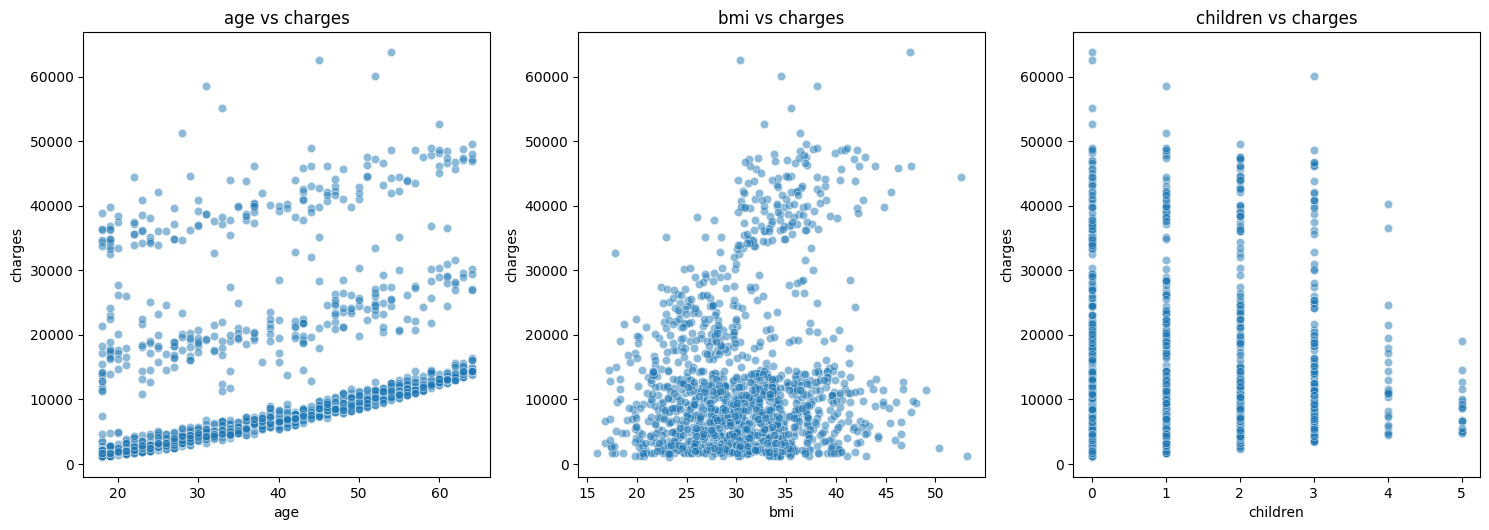

In [8]:
    # Scatter plots atribut/charges
def display_dist_vs_price_sp(df):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(['age', 'bmi', 'children']):
        plt.subplot(2, 3, i+1)
        sns.scatterplot(data=df, x=col, y='charges', alpha=0.5)
        plt.title(f'{col} vs charges')
    plt.tight_layout()
    plt.show()

display_dist_vs_price_sp(df)


Create separate dataset with the outliers just as before

In [9]:
outliers2 = df[
    (df['charges'] > 50000)
]
print(df.shape)
print(outliers2.shape)

(1338, 8)
(7, 8)


What to do with outliers?
Since we have enough data, we drop them.

In [10]:
outliers_final = pd.concat([outliers, outliers2], ignore_index=False)
outliers_final = outliers_final[~outliers_final['id'].duplicated()] # Eliminem files duplicacdes

display(outliers_final.head(5))


,id,age,sex,bmi,children,smoker,region,charges
116,116,58,male,49.06,0,no,southeast,11381.32540
286,286,46,female,48.07,2,no,northeast,9432.92530
401,401,47,male,47.52,1,no,southeast,8083.91980
438,438,52,female,46.75,5,no,southeast,12592.53450
543,543,54,female,47.41,0,yes,southeast,63770.42801


In [11]:
# Eliminació dels outliers detectats (tenim moltes dades)
df_cleaned = df_final[~df_final['id'].isin(outliers_final['id'])]
print(f"S'han eliminat {outliers_final.shape[0]} outliers del conjunt de dades. Dades restants: {df_cleaned.shape[0]}")
display(df_cleaned.head(5))

S'han eliminat 16 outliers del conjunt de dades. Dades restants: 1322


,id,age,sex,bmi,children,smoker,region,charges,age_norm,bmi_norm,children_norm,charges_norm
0,0,19,female,27.900,0,yes,southwest,16884.92400,0.021739,0.321227,0.0,0.251611
1,1,18,male,33.770,1,no,southeast,1725.55230,0.000000,0.479150,0.2,0.009636
2,2,28,male,33.000,3,no,southeast,4449.46200,0.217391,0.458434,0.6,0.053115
3,3,33,male,22.705,0,no,northwest,21984.47061,0.326087,0.181464,0.0,0.333010
4,4,32,male,28.880,0,no,northwest,3866.85520,0.304348,0.347592,0.0,0.043816


Display of the cleaned dataset --> No more outliers should be observed

--- Dataset ---
Distribucions utilitzant boxplots


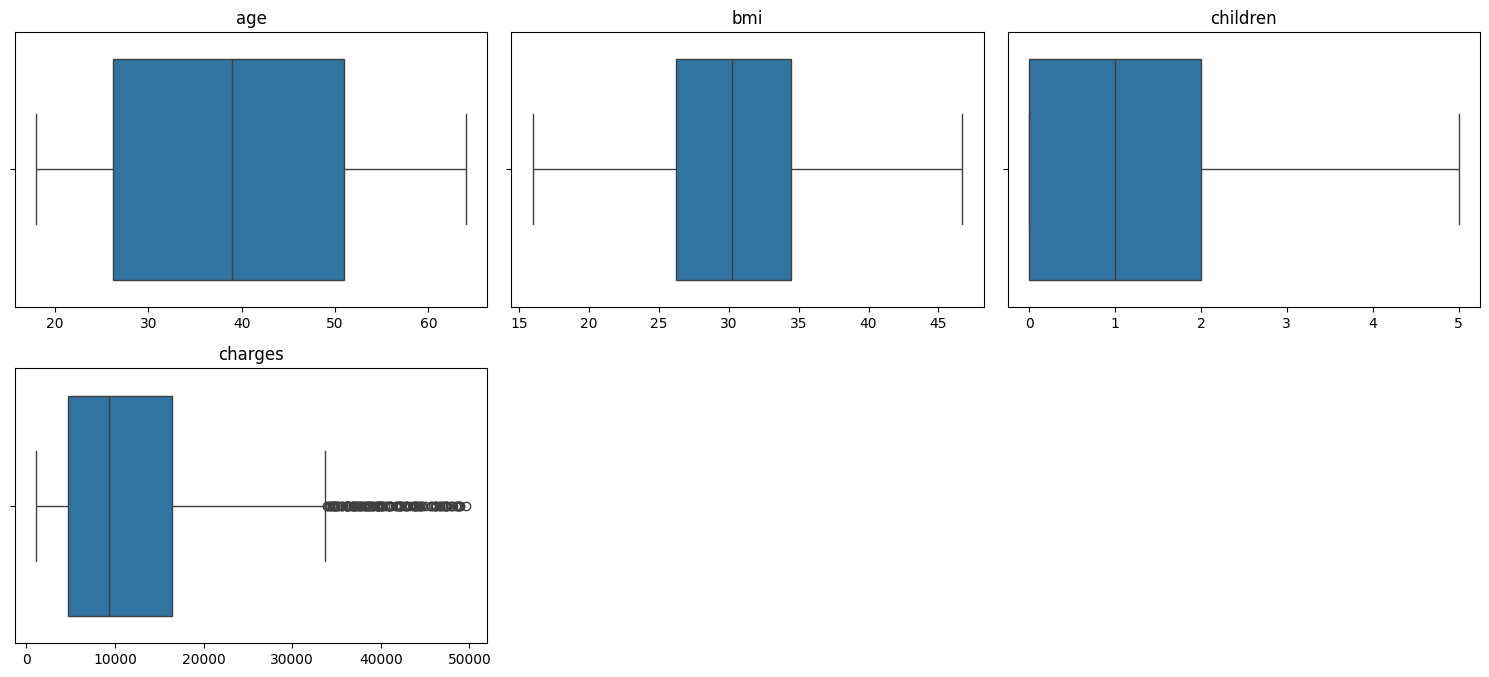

Distribucions vs Preu utilitzant scatter plots


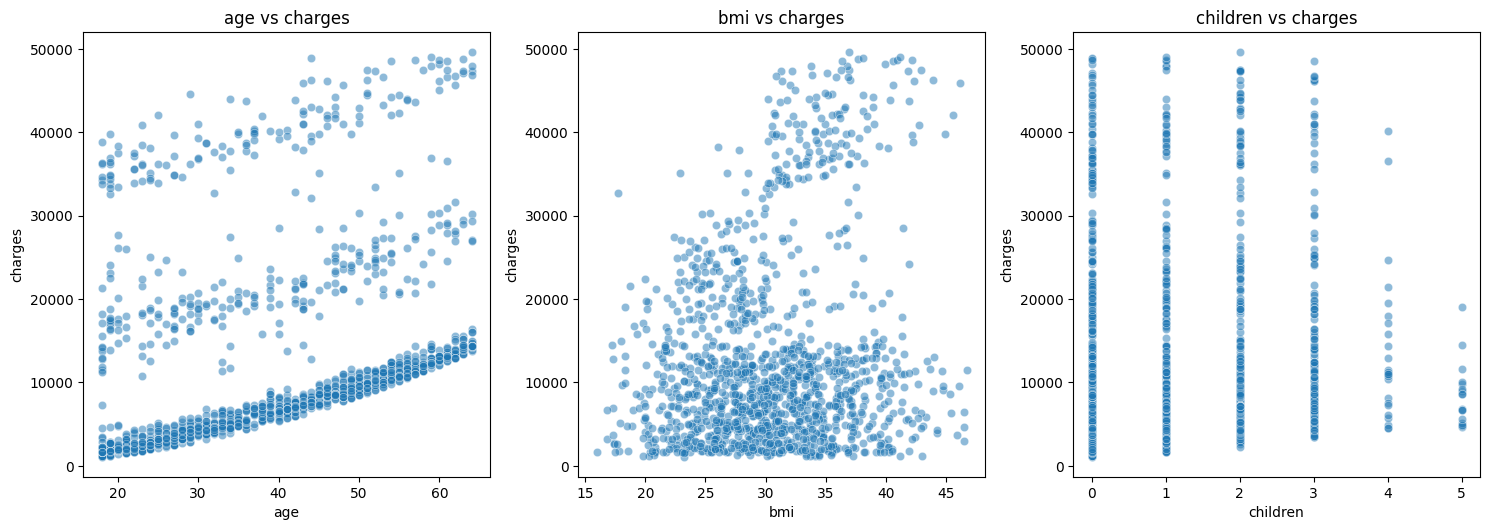

In [12]:
print("--- Dataset ---")
print("Distribucions utilitzant boxplots")
display_distribution_bp(df_cleaned)
print("Distribucions vs Preu utilitzant scatter plots")
display_dist_vs_price_sp(df_cleaned)

### Step 3: Categorical --> Numerical

In [13]:
# Convertir variables categòriques a numèriques utilitzant One-Hot Encoding
def categorical_to_numerical(df):
    # Identify categorical columns
    categorical_cols = ['sex', 'smoker', 'region']
    
    # Initialize OneHotEncoder
    encoder = OneHotEncoder(drop='first', sparse_output=False)  # dense array output
    
    # Fit and transform categorical columns
    encoded_array = encoder.fit_transform(df[categorical_cols])
    
    # Get encoded column names
    encoded_cols = encoder.get_feature_names_out(categorical_cols)
    
    # Create a DataFrame from encoded data
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)
    
    # Drop original categorical columns and join encoded ones
    df = df.drop(columns=categorical_cols)
    df = pd.concat([df, encoded_df], axis=1)
    
    return df

display(df_cleaned.head())
df_cleaned = categorical_to_numerical(df_cleaned)
display(df_cleaned.head())

,id,age,sex,bmi,children,smoker,region,charges,age_norm,bmi_norm,children_norm,charges_norm
0,0,19,female,27.900,0,yes,southwest,16884.92400,0.021739,0.321227,0.0,0.251611
1,1,18,male,33.770,1,no,southeast,1725.55230,0.000000,0.479150,0.2,0.009636
2,2,28,male,33.000,3,no,southeast,4449.46200,0.217391,0.458434,0.6,0.053115
3,3,33,male,22.705,0,no,northwest,21984.47061,0.326087,0.181464,0.0,0.333010
4,4,32,male,28.880,0,no,northwest,3866.85520,0.304348,0.347592,0.0,0.043816


,id,age,bmi,children,charges,age_norm,bmi_norm,children_norm,charges_norm,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0,19,27.900,0,16884.92400,0.021739,0.321227,0.0,0.251611,0.0,1.0,0.0,0.0,1.0
1,1,18,33.770,1,1725.55230,0.000000,0.479150,0.2,0.009636,1.0,0.0,0.0,1.0,0.0
2,2,28,33.000,3,4449.46200,0.217391,0.458434,0.6,0.053115,1.0,0.0,0.0,1.0,0.0
3,3,33,22.705,0,21984.47061,0.326087,0.181464,0.0,0.333010,1.0,0.0,1.0,0.0,0.0
4,4,32,28.880,0,3866.85520,0.304348,0.347592,0.0,0.043816,1.0,0.0,1.0,0.0,0.0


### Step 4: Train Test Split
 +Log Transform of the charges variable.

In [19]:

# Split the dataset into 80% training and 20% testing
dades_train, dades_test = train_test_split(df_cleaned, test_size=0.2, random_state=42, shuffle=True)
# Obtain X and y for train and test sets
X_train = dades_train.drop(columns=['charges', 'charges_norm', 'id', 'age', 'bmi', 'children'])
X_test = dades_test.drop(columns=['charges', 'charges_norm', 'id', 'age', 'bmi', 'children'])
y_train = np.log1p(dades_train['charges'])  # log-transform target --> Better for regression
y_test = np.log1p(dades_test['charges'])
y_train_original = dades_train['charges']
y_test_original = dades_test['charges']
y=pd.concat([y_train, y_test])
X=pd.concat([X_train, X_test])
# Store train and test sets
dades_train.to_csv("dades_train.csv", index=False)
dades_test.to_csv("dades_test.csv", index=False)
df_cleaned.to_csv("dades_cleaned.csv", index=False)

print("Train Test split saved as 'dades_train.csv' and 'dades_test.csv', Train and Test variables stored.")

Train Test split saved as 'dades_train.csv' and 'dades_test.csv', Train and Test variables stored.


# Implementation of MLR-F
Using scikit-learn library and prebuilt functions, with cross validation using k-fold (5)

Model Performance on Test Set (log-transformed target):
  Mean Squared Error (MSE): 62515806.77
  Mean Absolute Error (MAE): 4053.17
  Mean Absolute Percentage Error (MAPE): 0.2523
  Prediction Hitrate: 74.77%

Cross-Validation Results (5-Fold, log-transformed target):
  Average MSE: 0.20
  Average MAE: 0.28
  Average MAPE: 0.0302

Feature Importance (based on coefficients, log-space):
            Feature  Coefficient
0          age_norm     1.599634
4        smoker_yes     1.527624
2     children_norm     0.514287
1          bmi_norm     0.465989
5  region_northwest    -0.066029
3          sex_male    -0.074834
7  region_southwest    -0.145382
6  region_southeast    -0.165689


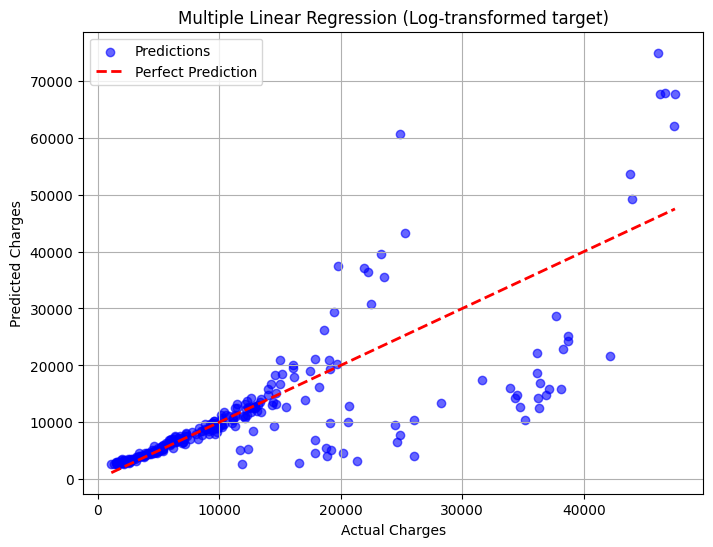

In [ ]:
# --------------------------
# 1. Train the Linear Model
# --------------------------
mlr = LinearRegression()
mlr.fit(X_train, y_train)

# --------------------------
# 2. Make predictions (log-space)
# --------------------------
y_pred_log = mlr.predict(X_test)

# Convert predictions back to original scale
y_pred = np.expm1(y_pred_log)

# --------------------------
# 3. Evaluate performance on test set
# --------------------------
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred)
hitrate = (1 - mape) * 100

print("Model Performance on Test Set (log-transformed target):")
print(f"  Mean Squared Error (MSE): {mse:.2f}")
print(f"  Mean Absolute Error (MAE): {mae:.2f}")
print(f"  Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"  Prediction Hitrate: {hitrate:.2f}%")

# --------------------------
# 4. Cross-validation (5-fold) in log-space
# --------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mse = -cross_val_score(mlr, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_mae = -cross_val_score(mlr, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
cv_mape = -cross_val_score(mlr, X_train, y_train, cv=kf, scoring='neg_mean_absolute_percentage_error')

print("\nCross-Validation Results (5-Fold, log-transformed target):")
print(f"  Average MSE: {cv_mse.mean():.2f}")
print(f"  Average MAE: {cv_mae.mean():.2f}")
print(f"  Average MAPE: {cv_mape.mean():.4f}")

# --------------------------
# 5. Feature Importance
# --------------------------
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': mlr.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance (based on coefficients, log-space):")
print(feature_importance)

# --------------------------
# 6. Regression Display
# --------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test_original, y_pred, alpha=0.6, color='blue', label='Predictions')
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Multiple Linear Regression (Log-transformed target)')
plt.legend()
plt.grid(True)
plt.show()


# Implementation of BP-F
Neural network implemented using tensorflow, GridSearchCV for cross validation and parameter search and plotting loss curves as well as the prediction scatter

## BP-F without Regularization Techniques

Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\xaviv\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\xaviv\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Best Parameters Found: {'activation': 'tanh', 'batch_size': 8, 'epochs': 200, 'learning_rate': 0.001, 'neurons': 32}
Best MSE (CV): 0.1385057924912275
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

========= MODEL PERFORMANCE ==========
MSE:  23411015.6007
MAE:  2420.1177
MAPE: 18.80%


Train Error: 2.19%
Test Error: 2.39%


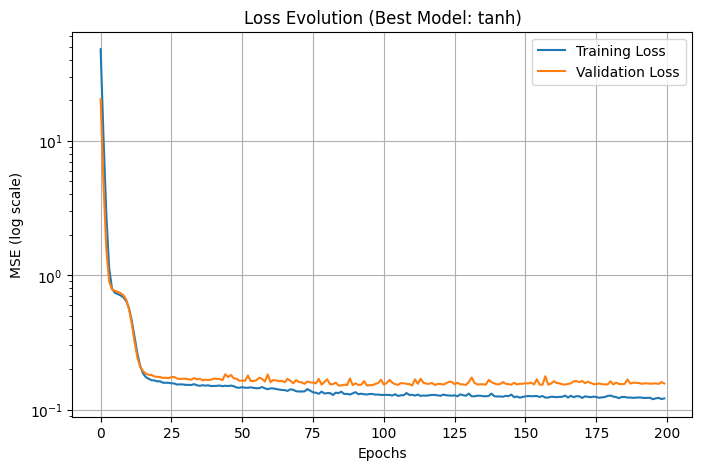

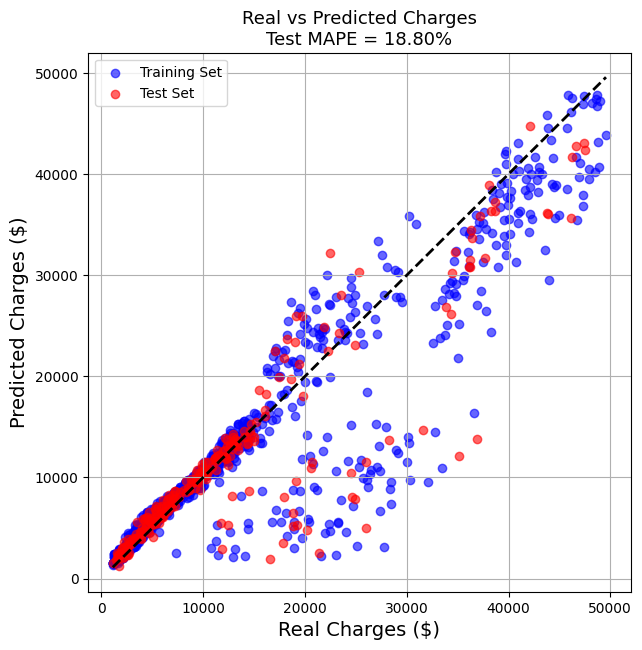

In [35]:
# ====== Neural Network with GridSearchCV ======

# --------------------------------
# 1. Define model creation function
# --------------------------------
def create_model(learning_rate=0.01, activation='relu', neurons=16):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons, input_dim=X_train.shape[1], activation=activation),
        tf.keras.layers.Dense(neurons // 2, activation=activation),
        tf.keras.layers.Dense(1, activation='linear')  # regression output
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# -----------------------------------
# 2. Wrap Keras model for GridSearchCV
# -----------------------------------
regressor = KerasRegressor(
    model=create_model,
    learning_rate=0.01,
    activation='relu',
    neurons=16,
    epochs=100,
    batch_size=16,
    verbose=0
)

# ----------------------------
# 3. Define hyperparameter grid
# ----------------------------
param_grid = {
    "learning_rate": [0.001, 0.01, 0.05],
    "activation": ["relu", "tanh"],
    "neurons": [8, 16, 32],
    "batch_size": [8, 16],
    "epochs": [100, 200]
}

grid = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

# ------------------------------------------------
# 4. Fit grid search
# ------------------------------------------------
grid_result = grid.fit(X_train, y_train)

print("✅ Best Parameters Found:", grid_result.best_params_)
print("Best MSE (CV):", -grid_result.best_score_)

# ------------------------------------------------
# 5. Refit best model on all training data
# ------------------------------------------------
best_params = grid_result.best_params_
best_model = create_model(
    learning_rate=best_params['learning_rate'],
    activation=best_params['activation'],
    neurons=best_params['neurons']
)

history = best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=0,
    #verbose=1,
    shuffle=True
)

# ------------------------------------------------
# 6. Evaluate and Predict
# ------------------------------------------------
y_train_pred = best_model.predict(X_train).flatten()
y_test_pred = best_model.predict(X_test).flatten()

y_train_pred_original = np.expm1(y_train_pred)
y_test_pred_original = np.expm1(y_test_pred)

mse = mean_squared_error(y_test_original, y_test_pred_original)
mae = mean_absolute_error(y_test_original, y_test_pred_original)
mape = np.mean(np.abs((y_test_original - y_test_pred_original) / y_test_original)) * 100

print("\n========= MODEL PERFORMANCE ==========")
print(f"MSE:  {mse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print("========================================\n")

train_error = np.mean(np.abs(y_train_pred - y_train) / y_train) * 100
test_error = np.mean(np.abs(y_test_pred - y_test) / y_test) * 100

print(f"\nTrain Error: {train_error:.2f}%")
print(f"Test Error: {test_error:.2f}%")

# ------------------------------------------------
# 7. Plot Training Loss
# ------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')
plt.title(f"Loss Evolution (Best Model: {best_params['activation']})")
plt.xlabel('Epochs')
plt.ylabel('MSE (log scale)')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------
# 8. Plot Real vs Predicted Charges
# ------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 7))
# Training points
ax.scatter(y_train_original, y_train_pred_original, c='blue', alpha=0.6, label='Training Set')
# Test points
ax.scatter(y_test_original, y_test_pred_original, c='red', alpha=0.6, label='Test Set')
# Identity line y = x
min_val = min(y_train_original.min(), y_test_original.min(), y_train_pred_original.min(), y_test_pred_original.min())
max_val = max(y_train_original.max(), y_test_original.max(), y_train_pred_original.max(), y_test_pred_original.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
# Labels
ax.set_xlabel("Real Charges ($)", fontsize=14)
ax.set_ylabel("Predicted Charges ($)", fontsize=14)
ax.set_title(f"Real vs Predicted Charges\nTest MAPE = {mape:.2f}%", fontsize=13)
ax.legend()
ax.grid(True)
plt.show()

## BP-F With regularization techniques:
Usage of both L2 regularization and dropout, to compare the outputs to the neural network above and comment the improvement on the predictions

Fitting 3 folds for each of 144 candidates, totalling 432 fits


c:\Users\xaviv\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Best Parameters Found: {'activation': 'tanh', 'batch_size': 8, 'drop_rate': 0, 'epochs': 200, 'l2_lambda': 0.001, 'learning_rate': 0.001, 'neurons': 16}
Best CV MSE: 0.13709380543421693
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

========= MODEL PERFORMANCE ==========
MSE:  25128699.4973
MAE:  2348.2283
MAPE: 13.89%


Train Error: 1.70%
Test Error: 1.95%


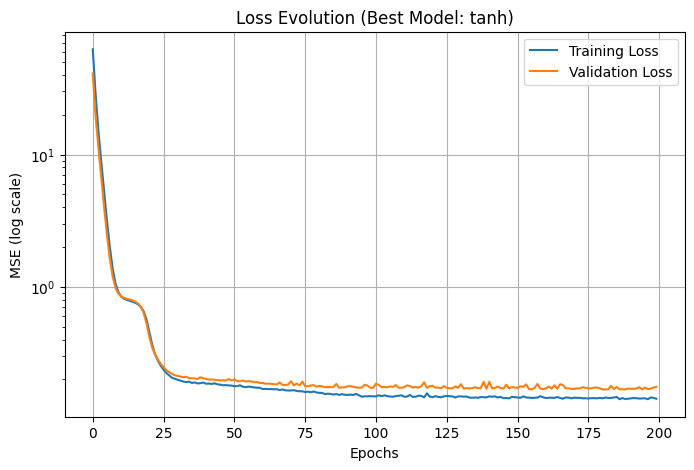

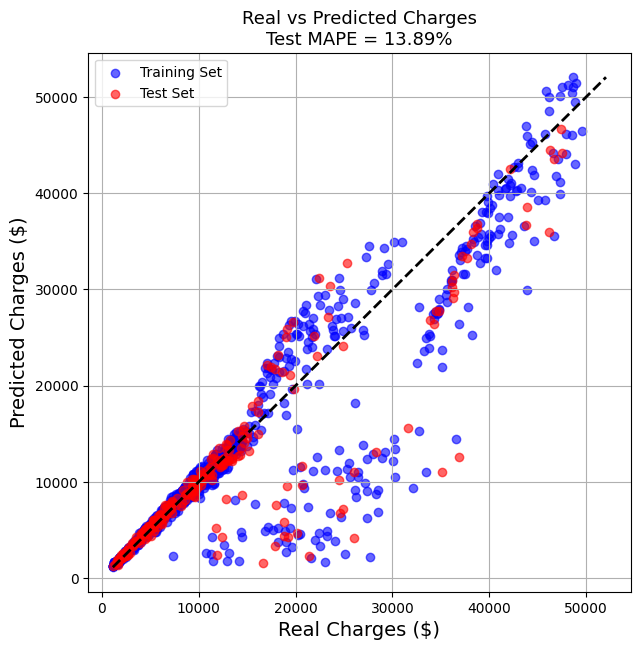

In [17]:
# =============================================
#   Neural Network with L2 + Dropout Regularization
#   (Full Pipeline with GridSearchCV)
# =============================================

# ---------------------------------------------
# 1. Define Model Creation Function
#    (Includes L2 + Dropout Regularization)
# ---------------------------------------------
def create_model(learning_rate=0.01, activation="relu", neurons=16, l2_lambda=0.001, drop_rate=0.2):

    l2_reg = tf.keras.regularizers.l2(l2_lambda)

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            neurons,
            input_dim=X_train.shape[1],
            activation=activation,
            kernel_regularizer=l2_reg
        ),
        tf.keras.layers.Dropout(drop_rate),

        tf.keras.layers.Dense(
            neurons // 2,
            activation=activation,
            kernel_regularizer=l2_reg
        ),
        tf.keras.layers.Dropout(drop_rate),

        tf.keras.layers.Dense(1, activation="linear"),
    ])

    model.compile(
        loss="mean_squared_error",
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    )
    return model


# ---------------------------------------------
# 2. Wrap in KerasRegressor for GridSearchCV
# ---------------------------------------------
regressor = KerasRegressor(
    model=create_model,
    learning_rate=0.01,
    activation="relu",
    neurons=16,
    l2_lambda=0.001,
    drop_rate=0.2,
    epochs=100,
    batch_size=16,
    verbose=0
)


# ---------------------------------------------
# 3. Hyperparameter Grid (Includes Both Regularizations while keeping same parameters, slower than before)
# ---------------------------------------------

param_grid = {
    "learning_rate": [0.001, 0.01, 0.05],
    "activation": ["relu", "tanh"],
    "neurons": [8, 16, 32],
    "batch_size": [8, 16],
    "epochs": [200],
    # Regularization parameters
    "l2_lambda": [0.0001, 0.001],
    "drop_rate": [0, 0.1]   #Check if dropout helps
}


grid = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)


# ---------------------------------------------
# 4. Run GridSearchCV
# ---------------------------------------------
grid_result = grid.fit(X_train, y_train)

print("✅ Best Parameters Found:", grid_result.best_params_)
print("Best CV MSE:", -grid_result.best_score_)


# ---------------------------------------------
# 5. Refit Best Model
# ---------------------------------------------
best_params = grid_result.best_params_

best_model = create_model(
    learning_rate=best_params['learning_rate'],
    activation=best_params['activation'],
    neurons=best_params['neurons'],
    l2_lambda=best_params['l2_lambda'],
    drop_rate=best_params['drop_rate']
)

history = best_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    shuffle=True,
    verbose=0
    #verbose=1
)


# ------------------------------------------------
# 6. Evaluate and Predict
# ------------------------------------------------
y_train_pred = best_model.predict(X_train).flatten()
y_test_pred = best_model.predict(X_test).flatten()

y_train_pred_original = np.expm1(y_train_pred)
y_test_pred_original = np.expm1(y_test_pred)

mse = mean_squared_error(y_test_original, y_test_pred_original)
mae = mean_absolute_error(y_test_original, y_test_pred_original)
mape = np.mean(np.abs((y_test_original - y_test_pred_original) / y_test_original)) * 100

print("\n========= MODEL PERFORMANCE ==========")
print(f"MSE:  {mse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print("========================================\n")

train_error = np.mean(np.abs(y_train_pred - y_train) / y_train) * 100
test_error = np.mean(np.abs(y_test_pred - y_test) / y_test) * 100

print(f"\nTrain Error: {train_error:.2f}%")
print(f"Test Error: {test_error:.2f}%")

# ------------------------------------------------
# 7. Plot Training Loss
# ------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')
plt.title(f"Loss Evolution (Best Model: {best_params['activation']})")
plt.xlabel('Epochs')
plt.ylabel('MSE (log scale)')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------
# 8. Plot Real vs Predicted Charges
# ------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 7))
# Training points
ax.scatter(y_train_original, y_train_pred_original, c='blue', alpha=0.6, label='Training Set')
# Test points
ax.scatter(y_test_original, y_test_pred_original, c='red', alpha=0.6, label='Test Set')
# Identity line y = x
min_val = min(y_train_original.min(), y_test_original.min(), y_train_pred_original.min(), y_test_pred_original.min())
max_val = max(y_train_original.max(), y_test_original.max(), y_train_pred_original.max(), y_test_pred_original.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
# Labels
ax.set_xlabel("Real Charges ($)", fontsize=14)
ax.set_ylabel("Predicted Charges ($)", fontsize=14)
ax.set_title(f"Real vs Predicted Charges\nTest MAPE = {mape:.2f}%", fontsize=13)
ax.legend()
ax.grid(True)
plt.show()


## Optional Part 1:
Study the effect of the different regularization techniques in the Neural Network used in the (BP-F)


+ Explain how the regularization is introduced and the parameters used:

//TODO

+ For each of the parameters, present the results of the prediction:

//TODO

# Implementation of BP 

## Class Neural Net
This class defines the backbone and functions in order to implement a Multilayer neural network implementing online / minibatch backpropagation. It is based off the [G] document


In [ ]:
class NeuralNet:
    """
    Multilayer neural network implementing online / minibatch backpropagation.
      - Layers indexed 0..L-1
      - w[0] is a dummy; weights for layer `lay` are in w[lay]
      - theta[0] is dummy same as above
      - xi[lay] holds activations for layer lay
      - h[lay] holds fields for layer lay (only for lay >= 1)
      - delta[lay] holds backprop delta values for layer lay (only for lay >= 1)
    Constructor arguments:
      layers: list-like with number of units per layer, e.g. [3,9,5,1]
      epochs: number of epochs to train
      eta: learning rate
      alpha: momentum
      fact: activation function name(s). Can be:
            * a single string ('sigmoid', 'relu', 'linear', 'tanh')
            * OR a list with one activation per layer, e.g. ['relu','relu','linear']
      val_pct: percentage of data for validation in [0,1] (0 -> no validation)
      batch_size: minibatch size (1 = online BP). Default 1.
    Public methods:
      fit(X, y)
      predict(X)
      loss_epochs() -> np.ndarray shape (epochs, 2) columns: [train_err, val_err]
    """

    def __init__(self, layers, epochs=100, eta=0.01, alpha=0.0,
                 fact='sigmoid', val_pct=0.2, batch_size=1, random_state=None):

        # architecture
        self.L = len(layers)
        self.n = list(layers)

        # allow single activation OR list of activations
        if isinstance(fact, str):
            self.fact = [fact.lower()] * self.L
        else:
            if len(fact) != self.L:
                raise ValueError("Length of 'fact' list must equal number of layers L.")
            self.fact = [f.lower() for f in fact]

        # activations, fields, deltas
        self.xi = [np.zeros(self.n[lay]) for lay in range(self.L)]
        self.h = [np.zeros(self.n[lay]) for lay in range(self.L)]  # h[0] not used (inputs)
        self.delta = [np.zeros(self.n[lay]) for lay in range(self.L)]

        # weights and thresholds (theta)
        # w[0] unused to match convention
        self.w = []
        self.w.append(np.zeros((1, 1)))  # dummy
        for lay in range(1, self.L):
            # shape: (n[lay], n[lay-1])
            self.w.append(np.zeros((self.n[lay], self.n[lay - 1])))

        # thresholds (theta) per layer: theta[0] dummy
        self.theta = [np.zeros(1)]  # dummy
        for lay in range(1, self.L):
            self.theta.append(np.zeros(self.n[lay]))

        # weight change matrices (for updates), and previous (for momentum)
        self.d_w = [None] * self.L
        self.d_w_prev = [None] * self.L
        for lay in range(self.L):
            if lay == 0:
                self.d_w[lay] = None
                self.d_w_prev[lay] = None
            else:
                self.d_w[lay] = np.zeros_like(self.w[lay])
                self.d_w_prev[lay] = np.zeros_like(self.w[lay])

        # threshold change arrays
        self.d_theta = [None] * self.L
        self.d_theta_prev = [None] * self.L
        for lay in range(self.L):
            if lay == 0:
                self.d_theta[lay] = None
                self.d_theta_prev[lay] = None
            else:
                self.d_theta[lay] = np.zeros(self.n[lay])
                self.d_theta_prev[lay] = np.zeros(self.n[lay])

        # training hyperparameters
        self.epochs = int(epochs)
        self.eta = float(eta)
        self.alpha = float(alpha)
        self.val_pct = float(val_pct)
        self.batch_size = int(batch_size)
        if random_state is not None:
            np.random.seed(random_state)

        # Internal bookkeeping
        self.loss_history = np.zeros((self.epochs, 2))  # columns: train_err, val_err

        # scaling statistics
        self._X_mean = None
        self._X_std = None
        self._y_mean = None
        self._y_std = None

        # initialize weights and thresholds
        self._init_weights()

    # ------------------------------
    # Initialization helpers
    # ------------------------------
    def _init_weights(self):
        # small random weights in [-0.5, 0.5]
        for lay in range(1, self.L):
            r = np.random.rand(self.n[lay], self.n[lay-1]) - 0.5
            # scale by small factor depending on fan-in to help initial training
            scale = 1.0 / max(1.0, np.sqrt(self.n[lay-1]))
            self.w[lay] = r * scale
            # thresholds small random as well
            self.theta[lay] = (np.random.rand(self.n[lay]) - 0.5) * scale
            # reset previous deltas
            self.d_w_prev[lay].fill(0.0)
            self.d_theta_prev[lay].fill(0.0)

    # ------------------------------
    # Activation functions and derivatives
    # g(h) and g'(h)
    # We compute derivatives receiving h and/or activation xi when useful.
    # Allow multiple activation functions.
    # ------------------------------
    def _activate(self, h, fact):
        if fact == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-h))
        elif fact == 'tanh':
            return np.tanh(h)
        elif fact == 'relu':
            return np.maximum(0.0, h)
        elif fact == 'linear':
            return h.copy()
        else:
            raise ValueError(f"Unknown activation function: {fact}")

    def _activate_derivative(self, h, xi, fact):
        if fact == 'sigmoid':
            return xi * (1 - xi)
        elif fact == 'tanh':
            # derivative = 1 - tanh(h)^2
            return 1 - xi * xi
        elif fact == 'relu':
            # derivative is 1 for h>0, 0 otherwise (non-differentiable at 0, choose 0)
            return (h > 0).astype(float)
        elif fact == 'linear':
            # derivative is 1
            return np.ones_like(h)
        else:
            raise ValueError(f"Unknown activation function: {fact}")

    # ------------------------------
    # Forward propagation for one (batch of) pattern(s)
    # X_single: shape (n_features,) or (n_features, ) ;
    # 
    # ------------------------------
    def _forward(self, x):
        """
        Feed-forward for a single input x (1D array). Assumes x is scaled appropriately.
        Updates self.xi and self.h for all layers and returns output activation (array).
        """
        # input layer activations
        self.xi[0] = x.copy()
        # propagate layer by layer
        for lay in range(1, self.L):
            # compute field h = W * xi_prev - theta
            # w[lay] shape (n_lay, n_prev), xi[lay-1] shape (n_prev,)
            self.h[lay] = self.w[lay].dot(self.xi[lay - 1]) - self.theta[lay]

            # activation per layer <<<
            act = self.fact[lay]
            self.xi[lay] = self._activate(self.h[lay], act)

        return self.xi[self.L - 1].copy()

    # ------------------------------
    # Backpropagation for a single pattern (online)
    # z is the desired target for this pattern (1D array of length n[L-1])
    # ------------------------------
    def _backprop_single(self, z):
        """
        Backpropagation for a single pattern with target z (1D array).
        Updates weights and thresholds in self.w and self.theta.
        """
        # ensure z is 1D array
        z = np.array(z).reshape(-1)

        # Output layer index
        out_lay = self.L - 1

        # delta at output layer: Δ(L)_i = g'(h(L)_i) * (o_i - z_i)
        o = self.xi[out_lay]

        # derivative uses proper activation <<<
        gprime_out = self._activate_derivative(self.h[out_lay], o, self.fact[out_lay])
        self.delta[out_lay] = gprime_out * (o - z)

        # backpropagate deltas to layers L-1 down to 1
        for lay in range(self.L - 1, 0, -1):
            if lay - 1 >= 1:
                # compute delta for layers using eq (12)
                gprime_prev = self._activate_derivative(
                    self.h[lay - 1], self.xi[lay - 1], self.fact[lay - 1]
                )
                # sum over i in current layer (lay): delta[lay][i] * w[lay][i, j]
                # w[lay] shape (n_lay, n_prev)
                # compute contribution per j (n_prev,)
                # sum_i delta_i * w_ij => (w[lay].T dot delta[lay]) shape (n_prev,)
                contrib = self.w[lay].T.dot(self.delta[lay])
                self.delta[lay - 1] = gprime_prev * contrib

        # now update weights and thresholds using Eq (14):
        for lay in range(1, self.L):
            # compute weight changes δω^(lay)_ij = -eta * delta_i * xi_prev_j + alpha * δω_prev
            # delta[lay] shape (n_lay,), xi[lay-1] shape (n_prev,)
            grad_w = np.outer(self.delta[lay], self.xi[lay - 1])  # shape (n_lay, n_prev)
            delta_w = -self.eta * grad_w + self.alpha * self.d_w_prev[lay]
            self.d_w[lay] = delta_w
            # update weights
            self.w[lay] = self.w[lay] + delta_w
            # thresholds: δθ = eta * delta + alpha * δθ_prev (note positive eta * delta)
            delta_theta = self.eta * self.delta[lay] + self.alpha * self.d_theta_prev[lay]
            self.d_theta[lay] = delta_theta
            self.theta[lay] = self.theta[lay] + delta_theta

            # store for momentum in next step
            self.d_w_prev[lay] = delta_w.copy()
            self.d_theta_prev[lay] = delta_theta.copy()

    # ------------------------------
    # Utility: compute dataset MSE error (0.5 * mean squared error)
    # X and y must be raw (unscaled), method will scale X and y internally using stored stats.
    # Returns scalar average of 0.5*(o - z)^2 across samples and outputs.
    # ------------------------------
    def _dataset_error(self, X, y):
        Xs = (X - self._X_mean) / self._X_std
        # handle y shape; we support y vector or 2D
        Y = np.atleast_2d(y)
        if Y.shape[0] == 1 and X.shape[0] > 1 and y.ndim == 1:
            # shape correction (n_samples, n_outputs)
            Y = Y.reshape(-1, 1) if y.ndim == 1 else Y
        # standardize y
        Ys = (Y - self._y_mean) / self._y_std
        p = Xs.shape[0]
        tot = 0.0
        for i in range(p):
            o = self._forward(Xs[i])
            # ensure shapes align
            diff = o - Ys[i].reshape(o.shape)
            tot += 0.5 * np.sum(diff * diff)
        # average over patterns (and over outputs implicitly)
        return tot / p

    # ------------------------------
    # Public API
    # ------------------------------
    def fit(self, X, y, verbose=False):
        """
        Train the network using provided dataset X (n_samples, n_features)
        and targets y (n_samples,) or (n_samples, n_outputs).

        Splits training/validation according to self.val_pct. Uses online/minibatch updates
        depending on self.batch_size. Stores training/validation loss per epoch in self.loss_history.
        """
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)

        n_samples = X.shape[0]
        # Convert y to 2D if single output
        if y.ndim == 1:
            y2 = y.reshape(-1, 1)
        else:
            y2 = y.copy()

        # store scaling stats (standardization)
        self._X_mean = X.mean(axis=0, keepdims=True)
        self._X_std = X.std(axis=0, keepdims=True)
        # avoid zeros
        self._X_std[self._X_std == 0.0] = 1.0

        self._y_mean = y2.mean(axis=0, keepdims=True)
        self._y_std = y2.std(axis=0, keepdims=True)
        self._y_std[self._y_std == 0.0] = 1.0

        # standardize all data
        Xs_all = (X - self._X_mean) / self._X_std
        Ys_all = (y2 - self._y_mean) / self._y_std

        # training/validation split
        if self.val_pct > 0.0:
            # shuffle indices and split
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            n_val = int(np.round(self.val_pct * n_samples))
            n_val = min(max(n_val, 1), n_samples - 1)  # ensure at least 1 train and 1 val if possible
            val_idx = indices[:n_val]
            train_idx = indices[n_val:]
            X_train = Xs_all[train_idx]
            Y_train = Ys_all[train_idx]
            X_val = Xs_all[val_idx]
            Y_val = Ys_all[val_idx]
        else:
            # use all for training, no validation
            X_train = Xs_all
            Y_train = Ys_all
            X_val = None
            Y_val = None

        n_train = X_train.shape[0]

        # training loop
        for ep in range(self.epochs):
            # shuffle training indices each epoch
            order = np.arange(n_train)
            np.random.shuffle(order)

            # minibatch grouping
            if self.batch_size <= 1:
                # online update
                for idx in order:
                    # forward
                    self._forward(X_train[idx])
                    # backprop and update (single pattern)
                    self._backprop_single(Y_train[idx])
            else:
                # partial batch updates: accumulate grads for each minibatch then apply eq (16)
                b = self.batch_size
                for start in range(0, n_train, b):
                    end = min(start + b, n_train)
                    inds = order[start:end]
                    # zero accumulators for grads
                    accumulated_dw = [None] * self.L
                    accumulated_dtheta = [None] * self.L
                    for lay in range(1, self.L):
                        accumulated_dw[lay] = np.zeros_like(self.w[lay])
                        accumulated_dtheta[lay] = np.zeros(self.n[lay])

                    # accumulate contributions over batch P
                    for idx in inds:
                        self._forward(X_train[idx])
                        # compute deltas only (without updating weights)
                        # output delta
                        out_lay = self.L - 1
                        o = self.xi[out_lay]
                        gprime_out = self._activate_derivative(self.h[out_lay], o, self.fact[out_lay])
                        self.delta[out_lay] = gprime_out * (o - Y_train[idx])

                        for lay in range(self.L - 1, 0, -1):
                            if lay - 1 >= 1:
                                gprime = self._activate_derivative(self.h[lay - 1], self.xi[lay - 1], self.fact[lay - 1])
                                contrib = self.w[lay].T.dot(self.delta[lay])
                                self.delta[lay - 1] = gprime * contrib

                        # accumulate gradients: sum over patterns in minibatch of delta_i * xi_prev_j
                        for lay in range(1, self.L):
                            grad_w = np.outer(self.delta[lay], self.xi[lay - 1])
                            accumulated_dw[lay] += grad_w
                            accumulated_dtheta[lay] += self.delta[lay]

                    # apply update for minibatch P using eq (16)
                    for lay in range(1, self.L):
                        delta_w = -self.eta * accumulated_dw[lay] + self.alpha * self.d_w_prev[lay]
                        self.w[lay] = self.w[lay] + delta_w
                        delta_theta = self.eta * accumulated_dtheta[lay] + self.alpha * self.d_theta_prev[lay]
                        self.theta[lay] = self.theta[lay] + delta_theta

                        # store for momentum
                        self.d_w_prev[lay] = delta_w.copy()
                        self.d_theta_prev[lay] = delta_theta.copy()

            # end epoch -> compute training and validation error (using original scaling stored)
            # compute using standardized data and the network (which expects standardized inputs & outputs)
            train_err = self._dataset_error(X, y2) if True else self._dataset_error(X_train, Y_train)  # use whole original for stable reporting
            # NOTE: _dataset_error expects raw X,y and will re-standardize using stored stats
            if X_val is not None:
                val_err = self._dataset_error(self._X_std * X_val + self._X_mean, (self._y_std * Y_val + self._y_mean))
            else:
                val_err = np.nan

            self.loss_history[ep, 0] = train_err
            self.loss_history[ep, 1] = val_err

            if verbose and ((ep + 1) % max(1, self.epochs // 10) == 0 or ep == 0):
                if X_val is not None:
                    print(f"Epoch {ep+1}/{self.epochs}, train_err={train_err:.6f}, val_err={val_err:.6f}")
                else:
                    print(f"Epoch {ep+1}/{self.epochs}, train_err={train_err:.6f}")

    def predict(self, X):
        """
        Predict outputs for raw inputs X (shape n_samples x n_features).
        Returns outputs in original (descaled) units and shape (n_samples, n_outputs) or (n_samples,) if single output.
        """
        X = np.asarray(X, dtype=float)
        Xs = (X - self._X_mean) / self._X_std
        n_samples = Xs.shape[0]
        outs = []
        for i in range(n_samples):
            o_scaled = self._forward(Xs[i])  # in standardized output units
            # descale
            o = o_scaled * self._y_std.reshape(o_scaled.shape) + self._y_mean.reshape(o_scaled.shape)
            outs.append(o)
        outs = np.vstack(outs)
        # if network single output, return 1D vector
        if outs.shape[1] == 1:
            return outs.ravel()
        return outs

    def loss_epochs(self):
        """
        Returns array shape (n_epochs, 2) with columns [train_error, val_error]
        """
        return self.loss_history.copy()


## Usage of NeuralNet
Once the model has been created, we need to train and evaluate the predictions made. For that, we need to call the defined functions on the class NeuralNet with our train/test split data.

In [ ]:
# ------------------------------------------------------
# 1) Define función para entrenar y evaluar un modelo
# ------------------------------------------------------

def evaluate_model(params, X_train, y_train, X_val, y_val):
    net = NeuralNet(
        layers=params["layers"],
        eta=params["eta"],
        alpha=params["alpha"],
        fact=params["fact"],
        batch_size=params["batch_size"],
        epochs=params["epochs"],
        val_pct=0.0,
        random_state=42
    )

    net.fit(X_train, y_train)
    
    # validation loss
    y_pred = net.predict(X_val)
    loss = np.mean((y_pred - y_val)**2)
    return loss, net


# ------------------------------------------------------
# 2) GRID SEARCH with dynamic activations per layer
# ------------------------------------------------------
n_features = X_train.shape[1]

layer_options = [
    [n_features, 8, 1],
    [n_features, 12, 8, 1],
    [n_features, 16, 12, 8, 1]
]

eta_options = [0.001, 0.01, 0.05]
alpha_options = [0.0, 0.5, 0.9]

# Base patterns (hidden activation, output activation)
fact_patterns = [
    ("relu", "linear"),
    ("tanh", "linear")
]

batch_sizes = [1, 8, 32]
epoch_options = [200]

print("Generating combinations...")

# List of param dictionaries
grid_combinations = []

for layers in layer_options:
    L = len(layers)

    hidden_count = L - 1  # number of hidden layers

    for (hidden_act, output_act) in fact_patterns:

        # Build activation list of correct length
        fact = [hidden_act] * hidden_count + [output_act]

        # add each full combination
        for eta in eta_options:
            for alpha in alpha_options:
                for bsz in batch_sizes:
                    for epochs in epoch_options:

                        grid_combinations.append({
                            "layers": layers,
                            "eta": eta,
                            "alpha": alpha,
                            "fact": fact,
                            "batch_size": bsz,
                            "epochs": epochs
                        })

print(f"Trying {len(grid_combinations)} configurations...\n")



# ------------------------------------------------------
# VALIDATION SPLIT
# ------------------------------------------------------
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

results = []
best_loss = float("inf")
best_params = None
best_model = None


# ------------------
# GRID SEARCH LOOP
# ------------------
for params in grid_combinations:
    #print("Probando:", params)

    val_loss, model = evaluate_model(params, X_subtrain, y_subtrain, X_val, y_val)
    results.append((val_loss, params))

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params
        best_model = model

print("\n=====================================")
print("BEST HYPERPARAMS FOUND:")
print(best_params)
print(f"Validation Loss: {best_loss:.6f}")
print("=====================================\n")


# ------------------------------------------------------
# 3) ENTRENAR MODELO FINAL CON TODOS LOS DATOS DE TRAIN
# ------------------------------------------------------
print("Training final model with best params...")

final_model = NeuralNet(
    layers=best_params["layers"],
    eta=best_params["eta"],
    alpha=best_params["alpha"],
    fact=best_params["fact"],
    batch_size=best_params["batch_size"],
    epochs=best_params["epochs"],
    val_pct=0.2,
    random_state=42
)

final_model.fit(X_train, y_train, verbose=True)


# ------------------------------------------------------
# 4) PREDICCIONES SOBRE TEST
# ------------------------------------------------------
y_train_pred = final_model.predict(X_train)
y_train_pred_original = np.expm1(y_train_pred)
y_test_pred = final_model.predict(X_test)
y_test_pred_original = np.expm1(y_test_pred)

mse = mean_squared_error(y_test_original, y_test_pred_original)
mae = mean_absolute_error(y_test_original, y_test_pred_original)
mape = np.mean(np.abs((y_test_original - y_test_pred_original) / y_test_original)) * 100
r2 = r2_score(y_test_original, y_test_pred_original)

print("\n========= MODEL PERFORMANCE ==========")
print(f"MSE:  {mse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2: {r2:.4f}")
print("========================================\n")


# ------------------------------------------------------
# 5) GRÁFICOS
# ------------------------------------------------------

# --- Loss curve ---
losses = final_model.loss_epochs()
plt.figure(figsize=(8,5))
plt.plot(losses[:,0], label="Train loss")
plt.plot(losses[:,1], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


# --- Predicted vs Real ---
fig, ax = plt.subplots(figsize=(7, 7))
# Training points
ax.scatter(y_train_original, y_train_pred_original, c='blue', alpha=0.6, label='Training Set')
# Test points
ax.scatter(y_test_original, y_test_pred_original, c='red', alpha=0.6, label='Test Set')
# Identity line y = x
min_val = min(y_train_original.min(), y_test_original.min(), y_train_pred_original.min(), y_test_pred_original.min())
max_val = max(y_train_original.max(), y_test_original.max(), y_train_pred_original.max(), y_test_pred_original.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
# Labels
ax.set_xlabel("Real Charges ($)", fontsize=14)
ax.set_ylabel("Predicted Charges ($)", fontsize=14)
ax.set_title(f"Real vs Predicted Charges\nTest MAPE = {mape:.2f}%", fontsize=13)
ax.legend()
ax.grid(True)
plt.show()


# Optional Part 3: Ensemble Learning Models


## Random Forest

Fitting 3 folds for each of 72 candidates, totalling 216 fits
===== Best RF Parameters =====
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

===== REAL-SCALE OOB Performance =====
OOB MSE (real): 21983028.02
OOB MAE (real): 2325.12


c:\Users\xaviv\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


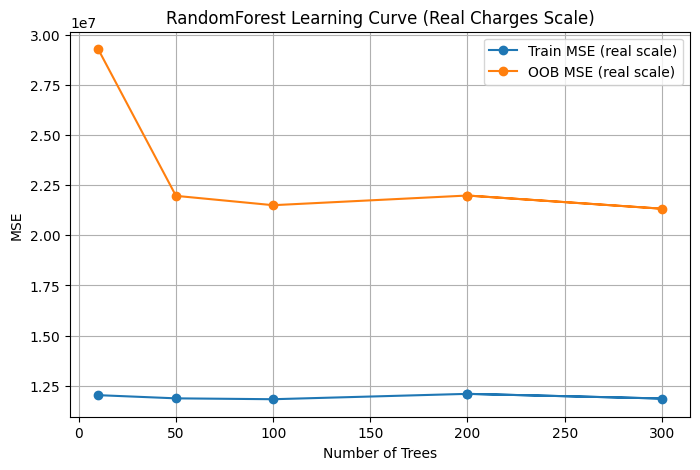


===== Final Test Results (Real Scale) =====
MSE: 22750607.08
MAE: 2363.58
R²: 0.8019
MAPE: 19.14%


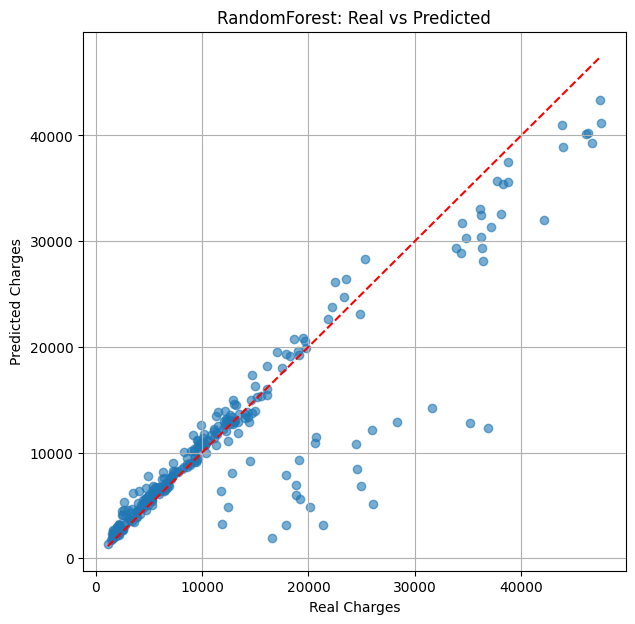

In [18]:
# ============================================
# RandomForest + GridSearchCV + Real-scale OOB
# ============================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# 1. Base model (OOB enabled)
# ------------------------------------------------------------
rf = RandomForestRegressor(
    random_state=42,
    oob_score=True,
    bootstrap=True
)

# ---------------------------
# 2. Hyperparameter grid
# ---------------------------
param_grid_rf = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

# -------------------------------------
# 3. Grid Search
# -------------------------------------
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

print("===== Best RF Parameters =====")
print(grid_search_rf.best_params_)

# --------------------------------------------------------
# 4. Fit final model with best params (OOB on log-scale)
# --------------------------------------------------------
best_params_rf = grid_search_rf.best_params_

final_rf = RandomForestRegressor(
    random_state=42,
    oob_score=True,
    bootstrap=True,
    **best_params_rf
)

final_rf.fit(X_train, y_train)  # STILL on log-scale internally

# =======================================================================
# 5. Compute OOB predictions on real-scale (convert log → real)
# =======================================================================
# OOB score is R2 on log-scale. To compute REAL OOB ERRORS, we must rebuild predictions:

# Access per-sample OOB predictions:
oob_log_pred = final_rf.oob_prediction_

# Convert to REAL SCALE:
oob_pred_real = np.expm1(oob_log_pred)
y_train_real = y_train_original.values

# Real-scale OOB errors:
oob_mse_real = mean_squared_error(y_train_real, oob_pred_real)
oob_mae_real = mean_absolute_error(y_train_real, oob_pred_real)

print("\n===== REAL-SCALE OOB Performance =====")
print(f"OOB MSE (real): {oob_mse_real:.2f}")
print(f"OOB MAE (real): {oob_mae_real:.2f}")

# =======================================================================
# 6. Real-scale learning curve (train & OOB)
# =======================================================================
train_mse_curve_real = []
oob_mse_curve_real = []
n_trees_list = [10, 50, 100, 200, 300, best_params_rf["n_estimators"]]

for n in n_trees_list:
    model_tmp = RandomForestRegressor(
        random_state=42,
        oob_score=True,
        bootstrap=True,
        n_estimators=n,
        max_depth=best_params_rf["max_depth"],
        min_samples_split=best_params_rf["min_samples_split"],
        min_samples_leaf=best_params_rf["min_samples_leaf"],
        max_features=best_params_rf["max_features"]
    )
    model_tmp.fit(X_train, y_train)

    # ---- TRAIN MSE (REAL SCALE) ----
    train_pred_log_tmp = model_tmp.predict(X_train)
    train_pred_real_tmp = np.expm1(train_pred_log_tmp)
    train_mse_curve_real.append(mean_squared_error(y_train_real, train_pred_real_tmp))

    # ---- OOB MSE (REAL SCALE) ----
    oob_log_tmp = model_tmp.oob_prediction_
    oob_real_tmp = np.expm1(oob_log_tmp)
    oob_mse_curve_real.append(mean_squared_error(y_train_real, oob_real_tmp))

# Plot learning curve
plt.figure(figsize=(8,5))
plt.plot(n_trees_list, train_mse_curve_real, marker="o", label="Train MSE (real scale)")
plt.plot(n_trees_list, oob_mse_curve_real, marker="o", label="OOB MSE (real scale)")
plt.xlabel("Number of Trees")
plt.ylabel("MSE")
plt.title("RandomForest Learning Curve (Real Charges Scale)")
plt.legend()
plt.grid(True)
plt.show()

# =======================================================================
# 7. Final predictions on TEST (real scale)
# =======================================================================
y_pred_log = final_rf.predict(X_test)
y_pred_real = np.expm1(y_pred_log)
y_real = y_test_original.values

# =======================================================================
# 8. Final metrics
# =======================================================================
mse = mean_squared_error(y_real, y_pred_real)
mae = mean_absolute_error(y_real, y_pred_real)
r2 = r2_score(y_real, y_pred_real)
mape = np.mean(np.abs((y_real - y_pred_real) / y_real)) * 100

print("\n===== Final Test Results (Real Scale) =====")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# =======================================================================
# 9. Real vs Predicted Plot
# =======================================================================
plt.figure(figsize=(7,7))
plt.scatter(y_real, y_pred_real, alpha=0.6)
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--')
plt.xlabel("Real Charges")
plt.ylabel("Predicted Charges")
plt.title("RandomForest: Real vs Predicted")
plt.grid(True)
plt.show()


## XGBoost
(Recommended by the teacher)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
===== Mejores parámetros encontrados =====
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


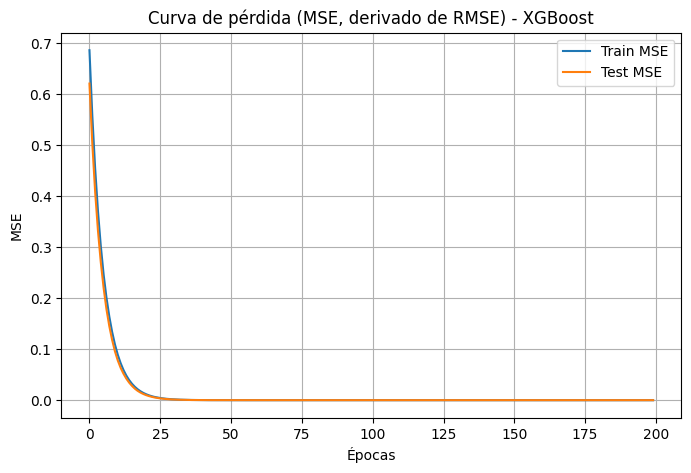


===== Resultados finales =====
MSE: 15434.43
MAE: 66.58
MAPE: 0.61%
R²: 0.9999


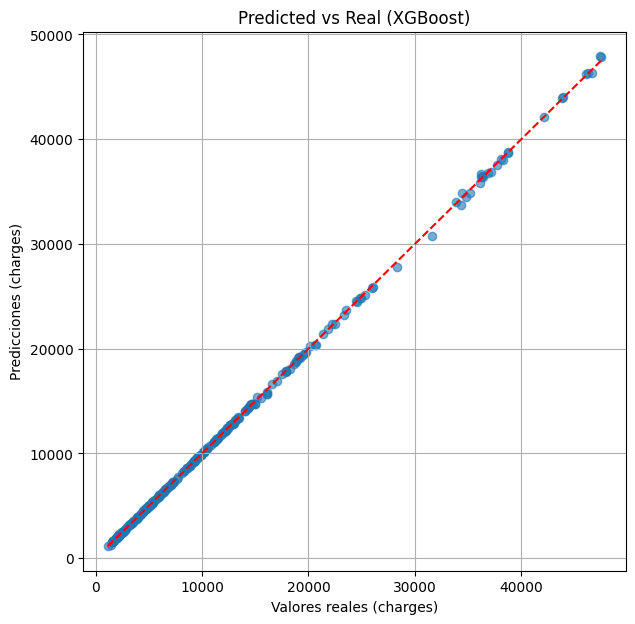

In [21]:
# ====================================
# XGBoost + GridSearchCV + MSE + Loss Curve
# ====================================

# 1. Cargar CSV
df = pd.read_csv("dades_cleaned.csv")

# 2. Separar X (features) e y (target)
X = df.drop(columns=["charges"])
y = df["charges"]

# 3. Aplicar logaritmo a y
y_log = np.log(y)

# 4. Dividir en train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# 5. Modelo base
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    eval_metric="rmse"
)

# 6. Grid de hiperparámetros
param_grid = {
    "n_estimators": [200, 400],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# 7. GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=1,
    n_jobs=-1
)

# 8. Entrenar búsqueda
grid_search.fit(X_train, y_train)

# 9. Mostrar mejores parámetros
print("===== Mejores parámetros encontrados =====")
print(grid_search.best_params_)

# 10. Entrenar modelo final con validación
best_params = grid_search.best_params_
final_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    eval_metric="rmse",  # rmse para entrenamiento
    **best_params
)

eval_set = [(X_train, y_train), (X_test, y_test)]

final_model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

# 11. Graficar curva de pérdida (convertida a MSE)
results = final_model.evals_result()
epochs = len(results["validation_0"]["rmse"])

train_mse = np.square(results["validation_0"]["rmse"])
test_mse = np.square(results["validation_1"]["rmse"])

plt.figure(figsize=(8,5))
plt.plot(range(epochs), train_mse, label="Train MSE")
plt.plot(range(epochs), test_mse, label="Test MSE")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.title("Curva de pérdida (MSE, derivado de RMSE) - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

# 12. Predicciones finales
y_pred_log = final_model.predict(X_test)
y_pred = np.exp(y_pred_log)
y_real = np.exp(y_test)

# 13. Métricas finales (MSE, MAE, R2, % error)
mse = mean_squared_error(y_real, y_pred)
mae = mean_absolute_error(y_real, y_pred)
r2 = r2_score(y_real, y_pred)
mean_percentage_error = np.mean(np.abs((y_real - y_pred) / y_real)) * 100

print("\n===== Resultados finales =====")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mean_percentage_error:.2f}%")
print(f"R²: {r2:.4f}")

# 14. Gráfica Predicted vs Real
plt.figure(figsize=(7,7))
plt.scatter(y_real, y_pred, alpha=0.6)
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--')
plt.xlabel("Valores reales (charges)")
plt.ylabel("Predicciones (charges)")
plt.title("Predicted vs Real (XGBoost)")
plt.grid(True)
plt.show()


Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\xaviv\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


===== Best XGBoost Hyperparameters =====
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


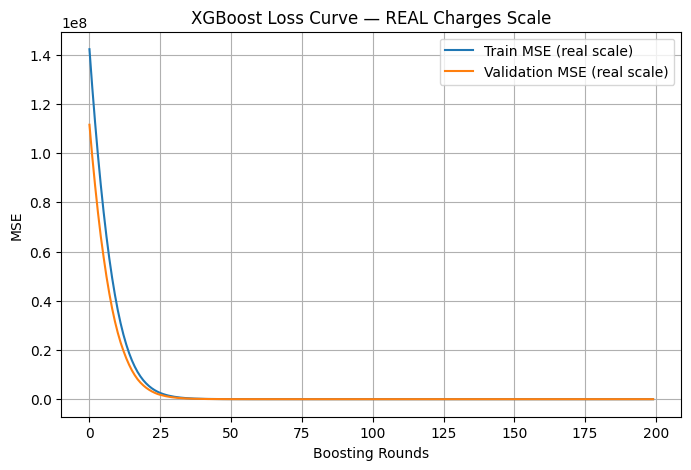


===== FINAL XGBOOST RESULTS (REAL SCALE) =====
MSE:  15485.34
MAE:  66.79
MAPE: 0.61%
R²:   0.9999


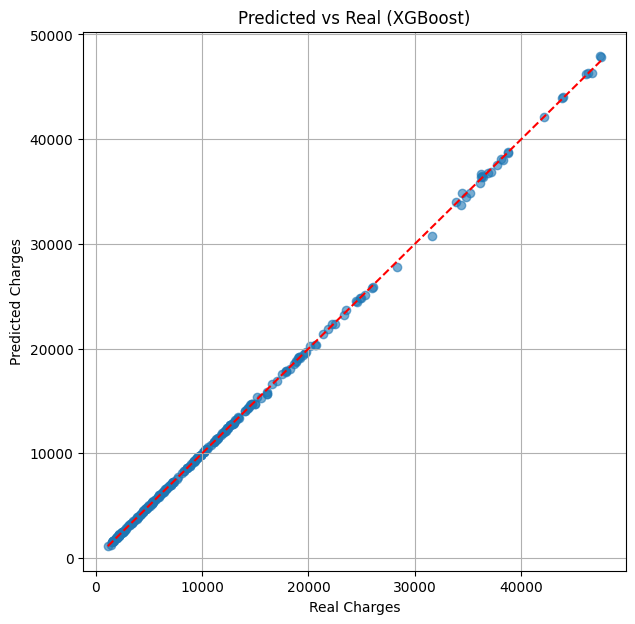

In [ ]:
# ==============================================
# XGBoost + GridSearchCV + REAL SCALE LOSS CURVE
# ==============================================

# -------------------------------------------------------------
# 1. Base model
# -------------------------------------------------------------
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    eval_metric="rmse"
)

# -------------------------------------------------------------
# 2. Hyperparameter grid
# -------------------------------------------------------------
param_grid = {
    "n_estimators": [200, 400],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# -------------------------------------------------------------
# 3. GridSearchCV
# -------------------------------------------------------------
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("===== Best XGBoost Hyperparameters =====")
print(grid_search.best_params_)

# -------------------------------------------------------------
# 4. Fit final model with best params
# -------------------------------------------------------------
best_params = grid_search.best_params_

final_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    eval_metric="rmse",
    **best_params
)

eval_set = [(X_train, y_train), (X_test, y_test)]

final_model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

# =============================================================
# 5. Learning curve in REAL SCALE
#    (Must recompute predictions at each boosting round)
# =============================================================
results = final_model.evals_result()
epochs = len(results["validation_0"]["rmse"])

train_mse_real = []
test_mse_real = []

# Convert originals once:
y_train_real = y_train_original.values
y_test_real = y_test_original.values

for i in range(epochs):
    # Predict using the first i+1 trees
    y_train_pred_log_i = final_model.predict(X_train, iteration_range=(0, i+1))
    y_test_pred_log_i = final_model.predict(X_test, iteration_range=(0, i+1))

    # Convert back to REAL charges
    y_train_pred_real_i = np.expm1(y_train_pred_log_i)
    y_test_pred_real_i = np.expm1(y_test_pred_log_i)

    # REAL MSE
    train_mse_real.append(mean_squared_error(y_train_real, y_train_pred_real_i))
    test_mse_real.append(mean_squared_error(y_test_real, y_test_pred_real_i))

# -------------------------------------------------------------
# 6. Plot REAL-SCALE learning curve
# -------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(epochs), train_mse_real, label="Train MSE (real scale)")
plt.plot(range(epochs), test_mse_real, label="Validation MSE (real scale)")
plt.xlabel("Boosting Rounds")
plt.ylabel("MSE")
plt.title("XGBoost Loss Curve — REAL Charges Scale")
plt.legend()
plt.grid(True)
plt.show()

# =============================================================
# 7. Final predictions (REAL SCALE)
# =============================================================
y_pred_log = final_model.predict(X_test)
y_pred_real = np.expm1(y_pred_log)

# =============================================================
# 8. Final metrics (REAL SCALE)
# =============================================================
mse = mean_squared_error(y_test_real, y_pred_real)
mae = mean_absolute_error(y_test_real, y_pred_real)
r2 = r2_score(y_test_real, y_pred_real)
mape = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real)) * 100

print("\n===== FINAL XGBOOST RESULTS =====")
print(f"MSE:  {mse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

# -------------------------------------------------------------
# 9. Real vs Predicted Plot
# -------------------------------------------------------------
plt.figure(figsize=(7,7))
plt.scatter(y_test_real, y_pred_real, alpha=0.6)
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()], 'r--')
plt.xlabel("Real Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs Real (XGBoost)")
plt.grid(True)
plt.show()
